In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cProfile
import pstats
import io

In [13]:
def calculate_magnetization(lattice):
    M = np.sum(lattice)
    return M / np.size(lattice)

def calculate_specific_heat(energies, kB, T, N, dimensions):
    avg_energy = np.mean(energies)
    energy_sq = np.mean(np.array(energies)**2)
    C = (energy_sq - avg_energy**2) / (kB * T**2 * N**dimensions)  # Specific heat
    return C

def initialize_lattice(N, dimensions, q, model_type='ising'):
    size = tuple(N for _ in range(dimensions))
    # Determine spin states based on the model type
    if model_type == 'ising':
        spin_states = [-1, 1]
    elif model_type == 'potts':
        spin_states = np.arange(q)
    else:
        raise ValueError("Unsupported model type. Please choose 'ising' or 'potts'.")
    
    lattice = np.random.choice(spin_states, size=size)
    
    return lattice

def calculate_energy(lattice, J, model_type='ising'):
    """Calculate the total energy of the lattice."""
    dimensions = len(lattice.shape)
    energy = 0

    if model_type == 'ising':
        for dim in range(dimensions):
            shift = np.roll(lattice, shift=-1, axis=dim)
            energy += -J * np.sum(lattice * shift)

    elif model_type == 'potts':
        # standard Potts model
        for dim in range(dimensions):
            forward_shift = np.roll(lattice, shift=-1, axis=dim)
            matches = np.sum(lattice == forward_shift)
            energy += -J * matches

    return energy

#########################################################################################

def calculate_delta_energy_ising(site_index, lattice, J):
    """Calculate the energy difference for a proposed spin flip in the Ising model."""
    dims = lattice.shape
    energy_before = 0
    energy_after = 0
    spin = lattice[site_index]
    proposed_spin = -spin  # Flip spin

    # Iterate over each dimension to consider nearest neighbors
    for dim in range(len(dims)):
        for shift in [-1, 1]:  # Look at the neighbor in both directions along each dimension
            neighbor_index = list(site_index)
            neighbor_index[dim] = (neighbor_index[dim] + shift) % dims[dim]  # Periodic boundary conditions
            neighbor_spin = lattice[tuple(neighbor_index)]
            energy_before -= J * spin * neighbor_spin
            energy_after -= J * proposed_spin * neighbor_spin

    return energy_after - energy_before

def calculate_delta_energy_potts(site_index, lattice, J, q):
    """Calculate the energy difference for a proposed spin change in the Potts model."""
    dims = lattice.shape
    spin = lattice[site_index]
    possible_spins = [x for x in range(q) if x != spin]
    proposed_spin = np.random.choice(possible_spins)

    deltaE = 0
    # Iterate over each dimension to consider nearest neighbors
    for dim in range(len(dims)):
        for shift in [-1, 1]:  # Look at the neighbor in both directions along each dimension
            neighbor_index = list(site_index)
            neighbor_index[dim] = (neighbor_index[dim] + shift) % dims[dim]  # Periodic boundary conditions
            neighbor_spin = lattice[tuple(neighbor_index)]
            # Only count matches, as non-matches don't contribute to energy in Potts model
            if spin == neighbor_spin:
                deltaE += J  # Losing a match
            if proposed_spin == neighbor_spin:
                deltaE -= J  # Gaining a match

    return deltaE

def metropolis_step(lattice, J, kB, T, q, model_type='ising', current_energy=None):
    dims = lattice.shape
    total_sites = np.prod(dims)
    site_index = np.unravel_index(np.random.randint(total_sites), dims)
    spin = lattice[site_index]

    if model_type == 'ising':
        deltaE = calculate_delta_energy_ising(site_index, lattice, J)
    else:
        deltaE = calculate_delta_energy_potts(site_index, lattice, J, q)

    # Update proposal
    if deltaE < 0 or np.random.rand() < np.exp(-deltaE / (kB * T)):
        proposed_spin = -spin if model_type == 'ising' else np.random.choice([x for x in range(q) if x != spin])
        lattice[site_index] = proposed_spin
        if current_energy is not None:
            current_energy += deltaE

    return deltaE, current_energy

def run_simulation(N, dimensions, T, kB, J, q, model_type='ising', steps=10000):
    T +=(10**-6)
    lattice = initialize_lattice(N, dimensions, q, model_type)
    current_energy = calculate_energy(lattice, J, model_type)
    energies = []
    magnetizations = np.zeros(steps)

    for step in range(steps):
        deltaE, current_energy = metropolis_step(lattice, J, kB, T, q, model_type, current_energy)
        energies.append(current_energy)
        magnetizations[step] = calculate_magnetization(lattice)

    C = calculate_specific_heat(energies,kB,T,N,dimensions)
    M = np.mean(magnetizations)
    return lattice, energies, magnetizations, C, M
########################################################################################

# Example usage
N = 64  # (atoms = N^d)
dim = 2
T = 2.28
kB = 1.0
J = 1.0 
q = 2  # spins
model_type = 'ising'  # 'ising' or 'potts'
steps = 100*q*N**dim*2#10000
print(steps)

lattice, energies, magnetizations, C, M = run_simulation(N, dim, T, kB, J, q, model_type, steps)
print(f"Final lattice:\n{lattice}")
print(f"Specific Heat: {C}")
print(f"Average Magnetization: {M}")



1638400
Final lattice:
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ...  1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [ 1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ...  1 -1 -1]]
Specific Heat: 7.39299899572343
Average Magnetization: -0.4305009761452675


In [14]:
print(steps)
print(len(energies),len(magnetizations))
ds_steps = np.arange(steps)[::1000]
ds_energies = energies[::1000]
ds_magnetizations = magnetizations[::1000]

1638400
1638400 1638400


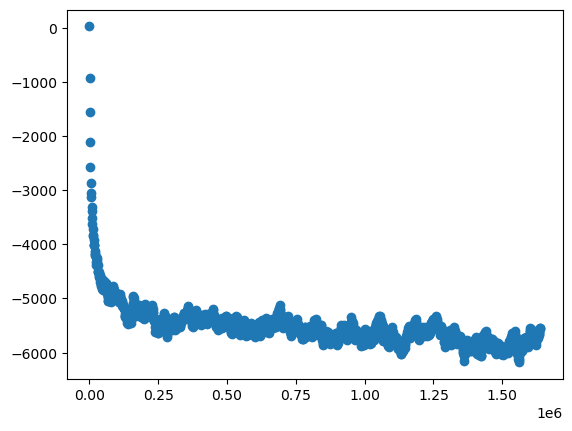

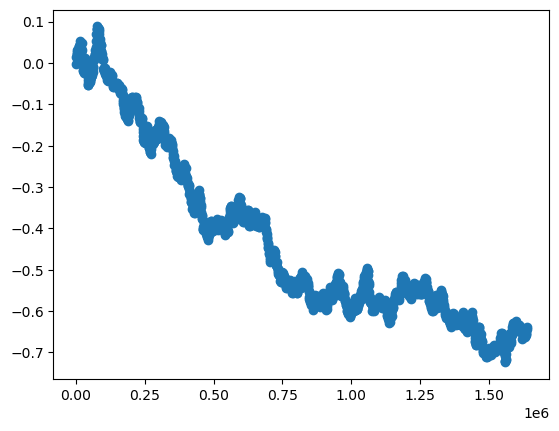

In [15]:
plt.scatter(ds_steps,ds_energies)
plt.show()
plt.scatter(ds_steps,ds_magnetizations)
plt.show()

In [7]:
profiler = cProfile.Profile()
profiler.enable()
for i in range(10):
    lattice, energies, magnetizations, C, M = run_simulation(N, dim, T, kB, J, q, model_type, steps)
profiler.disable()
#profiler.print_stats(sort='time')

# Create a BytesIO stream to capture the profiling data
s = io.StringIO()
# Create a Stats object from the profiler and sort the results by 'cumulative' time spent
ps = pstats.Stats(profiler, stream=s).sort_stats('cumulative')
# Print the stats to the StringIO stream
ps.print_stats(10)
# Now you can print the result from the StringIO object
print(s.getvalue())

         2374120 function calls in 5.639 seconds

   Ordered by: cumulative time
   List reduced from 58 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    5.640    2.820 /home/mishra94/.conda/envs/2022.10-py39/crit-phen/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3490(run_code)
        2    0.000    0.000    5.640    2.820 {built-in method builtins.exec}
       10    0.144    0.014    5.639    0.564 /tmp/ipykernel_510117/3401803351.py:141(run_simulation)
   100000    0.566    0.000    4.104    0.000 /tmp/ipykernel_510117/3401803351.py:121(metropolis_step)
   100000    2.322    0.000    2.335    0.000 /tmp/ipykernel_510117/3401803351.py:80(calculate_delta_energy_ising)
   200050    0.279    0.000    1.658    0.000 /home/mishra94/.conda/envs/2022.10-py39/crit-phen/lib/python3.10/site-packages/numpy/core/fromnumeric.py:71(_wrapreduction)
   100000    0.164    0.000    1.370    0.000 /tmp/

In [23]:
N = 32  # (atoms = N^d)
dim = 3
T = 1.0
kB = 1.0
J = 1.0 
q = 2  # spins
model_type = 'ising'  # 'ising' or 'potts'
steps = 10*q*N**dim*2
print(steps)

1310720


In [19]:
temps = np.arange(0.1,4,0.1)
results = np.zeros((len(temps),2))

for i in range(len(temps)):
    T = temps[i]
    lattice, energies, magnetizations, C, M = run_simulation(N, dim, T, kB, J, q, model_type, steps)
    results[i,0] = C
    results[i,1] = M


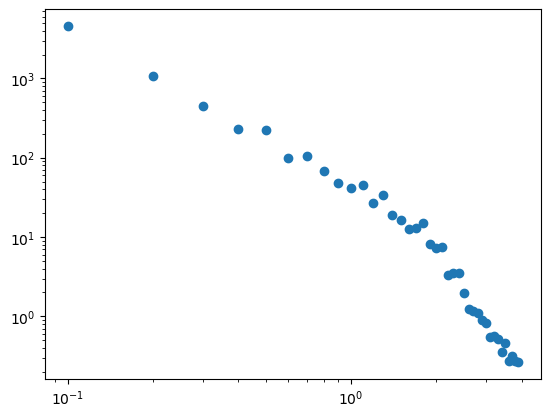

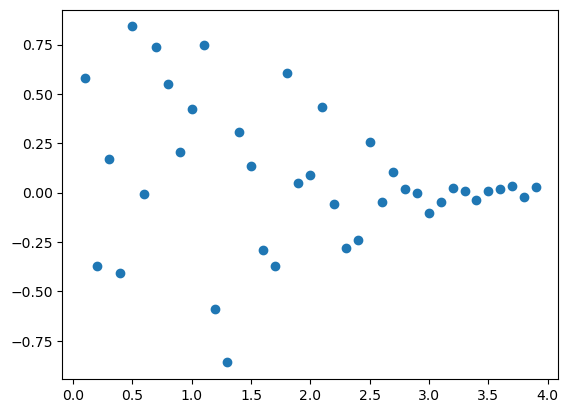

In [20]:

plt.scatter(temps,results[:,0])
plt.xscale('log')
plt.yscale('log')
plt.show()
plt.scatter(temps,results[:,1])
plt.xscale('linear')
plt.yscale('linear')
plt.show()